# Import Libraries

In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

import sys
import os

# Get the current working directory (which should be the directory containing the Jupyter notebook)
current_dir = os.getcwd()

# Construct the absolute path to the DataPreprocessing directory
data_preprocessing_path = os.path.join(current_dir, '..', 'DataPreprocessing')

# Add this path to sys.path
sys.path.append(os.path.abspath(data_preprocessing_path))

# Import custom preprocessing functions
from Preprocessing import filter_data, FeatureExtract


# Read and Preprocess data

In [35]:
# Initialize empty DataFrame for features and an empty array for labels
X = pd.DataFrame()
y = np.array([])

# Define the files and corresponding labels
files = {("ThaiBuon.txt", -1), ("ThaiVui.txt", 1), ("ThaiVui2.txt", 1), 
         ("ThaiCalm2.txt", 0), ("ThaiCalm.txt", 0), ("BachBuon.txt", 0), 
         ("ThanhfBuon.txt", -1), ("ThanhfVui.txt", 1), ("BachCalm.txt", 0), 
         ("SonBuon3.txt", -1), ("SonVui4.txt", 1), ("QuangCalm3.txt", 0),
         ("SonBuon4.txt", -1), ("ThanhfCalm.txt", 0), ("ThanhfVui2.txt", 1), 
         ("QuangBuon.txt", -1)}


# Load and preprocess each file
for filename, label in files:
    raw_data = np.loadtxt("../CollectedData/new_data/" + filename)
    
    # Preprocessing: Filter noise & use Short-time Fourier Transform
    raw_data = filter_data(raw_data)
    data = FeatureExtract(raw_data, plot=0)
    data_df = pd.DataFrame.from_dict(data)
    X = pd.concat([X, data_df], ignore_index=True)
    y = np.append(y, np.array([label] * data_df.shape[0]))

# Convert features to numpy array
X = X.values

# Define and Train the Stacking Classifier

In [36]:
# Define pipelines for individual models
svm_pipeline = make_pipeline(StandardScaler(), SVC(C=100, kernel="rbf", gamma="scale", probability=True))
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
gb_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100, random_state=42))

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_model = StackingClassifier(estimators=[
    ('svm', svm_pipeline),
    ('rf', rf_pipeline),
    ('gb', gb_pipeline)
], final_estimator=meta_model, cv=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)

# Train the stacking model
stacking_model.fit(X_train, y_train)
train_score = stacking_model.score(X_train, y_train)
test_score = stacking_model.score(X_test, y_test)
print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 0.998125
Test accuracy: 0.885


# Evaluate the Model

              precision    recall  f1-score   support

          -1       0.86      0.88      0.87       136
           0       0.93      0.94      0.94       144
           1       0.85      0.82      0.84       120

    accuracy                           0.89       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.89      0.88       400



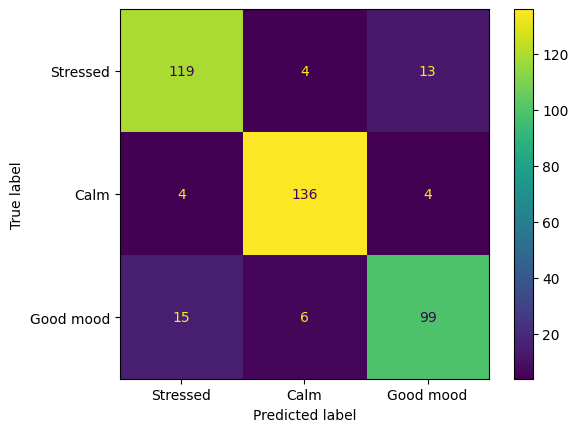

In [37]:
# Make predictions on the test set
y_pred = stacking_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, labels=[-1, 0, 1]))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Stressed", "Calm", "Good mood"])
disp.plot()
plt.savefig("../Figure/XThanh_ens_test.png")
plt.show()

# Cross-Validation and Visualization

Fold 1, Accuracy: 0.9000
Fold 2, Accuracy: 0.9000
Fold 3, Accuracy: 0.8900
Fold 4, Accuracy: 0.8750
Fold 5, Accuracy: 0.9100
Fold 6, Accuracy: 0.9200
Fold 7, Accuracy: 0.8850
Fold 8, Accuracy: 0.8900
Fold 9, Accuracy: 0.8700
Fold 10, Accuracy: 0.9000
Accuracy of folds: [0.9, 0.9, 0.89, 0.875, 0.91, 0.92, 0.885, 0.89, 0.87, 0.9]
K-Fold mean accuracy: 0.8939999999999999


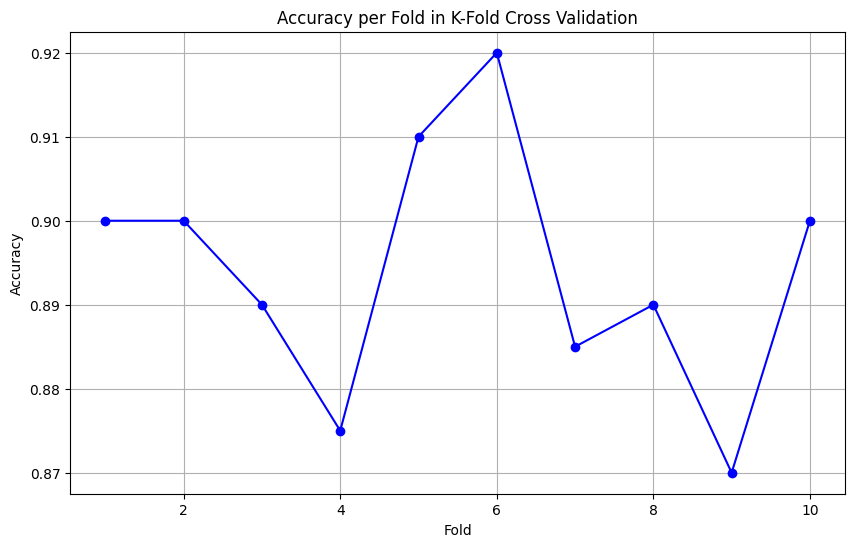

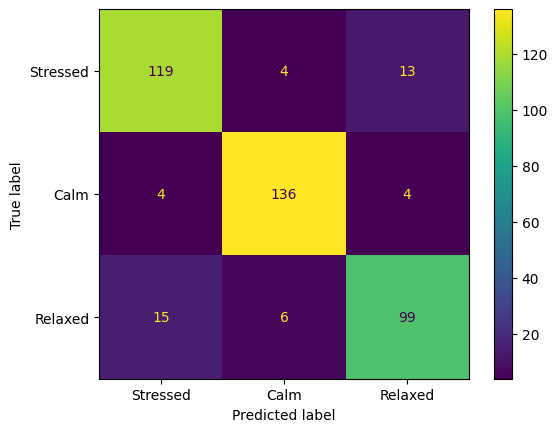

In [38]:
# Perform cross-validation and visualize the results
kf = StratifiedKFold(n_splits=10, shuffle=True)
accuracy_list = []
folds = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    # Split data into training and testing sets for cross-validation
    X_train_kf, X_test_kf = X[train_index], X[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    stacking_model.fit(X_train_kf, y_train_kf)
    
    accuracy = stacking_model.score(X_test_kf, y_test_kf)
    accuracy_list.append(accuracy)
    folds.append(fold)
    
    print(f"Fold {fold}, Accuracy: {accuracy:.4f}")

# Calculate mean accuracy
avg_accuracy = np.mean(accuracy_list)
print("Accuracy of folds:", accuracy_list)
print("K-Fold mean accuracy:", avg_accuracy)

# Plot the accuracy for each fold
plt.figure(figsize=(10, 6))
plt.plot(folds, accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold in K-Fold Cross Validation')
plt.grid(True)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Stressed", "Calm", "Relaxed"])
disp.plot()
plt.savefig("../Figure/XThanh_ens_kfold")
plt.show()


# Save the Model

In [39]:
# Train the stacking model on the entire dataset
stacking_model.fit(X, y)

# Save the model to a file
# with open("../trained_model/StackingClassifier_Enhanced.h5", "wb") as model_file:
#     pickle.dump(stacking_model, model_file)
pickle.dump(stacking_model, open("../trained_model/StackingClassifier_Enhanced.h5", "wb"))

# Test on New Data

In [40]:
## Test on new data
files = [("QuangBuon.txt", -1)]  # Example for testing new data
    
for filename, label in files:
    raw_data = np.loadtxt("../CollectedData/new_data/" + filename)
    data_df = pd.DataFrame.from_dict(FeatureExtract(raw_data, plot=0)).values
    
    # Manually scale new data
    scaler = StandardScaler().fit(X)
    data_df = scaler.transform(data_df)
    
    y_pred = stacking_model.predict(data_df)
    print("Real-time predictions:")
    print(y_pred)
    print("Accuracy:", accuracy_score(np.array([label] * y_pred.shape[0]), y_pred))

Real-time predictions:
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  0.  0. -1. -1. -1. -1. -1. -1.  0.
  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  0.]
Accuracy: 0.85
